In [62]:
# data from https://www.10xgenomics.com/datasets/xenium-human-brain-preview-data-1-standard
# Applications of Sptial Omics Intersession 2026
# Suwen's Project
# Assisted by ChatGPT

In [63]:
!pip install scanpy squidpy anndata numpy harmonypy matplotlib

In [64]:
!pip install igraph leidenalg

Import Statements

In [65]:
import scanpy as sc
import squidpy as sq
import anndata as ad
import numpy as np
import harmonypy as hm
import matplotlib.pyplot as plt

# Preprocessing

Load Data

In [66]:
# load data
healthy = sc.read_10x_mtx(
    "healthy",
    var_names="gene_symbols",
    cache=True
)

alz = sc.read_10x_mtx(
    "alzheimers",
    var_names="gene_symbols",
    cache=True
)

healthy.obs["condition"] = "Healthy"
alz.obs["condition"] = "Alzheimers"

print("Data loaded.")

Data loaded.


Filter Data

In [67]:
# quality control
def filter(adata):
    # mark mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")

    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=["mt"],
        percent_top=None,
        inplace=True
    )

    print("Number of genes before filtering:", adata.n_vars)
    print("Number of cells before filtering:", adata.n_obs)

    # filter cells with < 20 genes total
    adata = adata[(adata.obs.n_genes_by_counts > 20)]

    # filter genes expressed in fewer than 3 spots
    sc.pp.filter_genes(adata, min_cells=3)

    print("Number of genes after filtering:", adata.n_vars)
    print("Number of cells after filtering:", adata.n_obs, "\n")
    return adata

print("Filtering healthy genes.")
healthy = filter(healthy)
print("Filtering alzheimers genes")
alz = filter(alz)

Filtering healthy genes.
Number of genes before filtering: 319
Number of cells before filtering: 24406


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Number of genes after filtering: 319
Number of cells after filtering: 24043 

Filtering alzheimers genes
Number of genes before filtering: 354
Number of cells before filtering: 44955
Number of genes after filtering: 354
Number of cells after filtering: 35903 



In [ ]:
# visualization
# Make sure QC metrics exist
for a in [healthy, alz]:
    if "pct_counts_mt" not in a.obs:
        a.var["mt"] = a.var_names.str.startswith("MT")
        sc.pp.calculate_qc_metrics(a, qc_vars=["mt"], inplace=True)

# Combine datasets if you want side-by-side
adata = healthy.concatenate(alz, batch_key="condition", batch_categories=["Healthy", "Alzheimers"])

# Violin plot for QC metrics
qc_metrics = ["n_genes_by_counts", "total_counts", "pct_counts_mt"]

sc.pl.violin(
    adata,
    keys=qc_metrics,
    groupby="condition",   # shows healthy vs AD side by side
    rotation=45,
    jitter=0.4,
    multi_panel=True,      # separate panel per metric
    size=2                 # point size
)

Concatenate genes + Normalize

/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


normalized and log-transform data


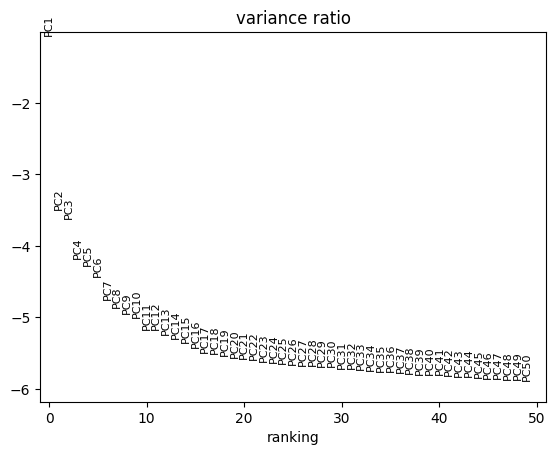

In [69]:
# concantenate genes
adata = ad.concat(
    [healthy, alz],
    join="outer",
    label="sample",
    keys=["Healthy", "Alzheimers"],
    fill_value=0
)
adata.obs_names_make_unique()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)

adata.raw = adata

print("normalized and log-transform data")

sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

sc.pp.highly_variable_genes(
    adata,
    batch_key="sample",
    n_top_genes=3000
)

adata = adata[:, adata.var.highly_variable]

Harmonize Data

In [70]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=50)

sc.pp.neighbors(
    adata,
    use_rep="X_pca"
)
sc.tl.umap(adata)

sc.tl.leiden(adata, key_added="leiden_pre")

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


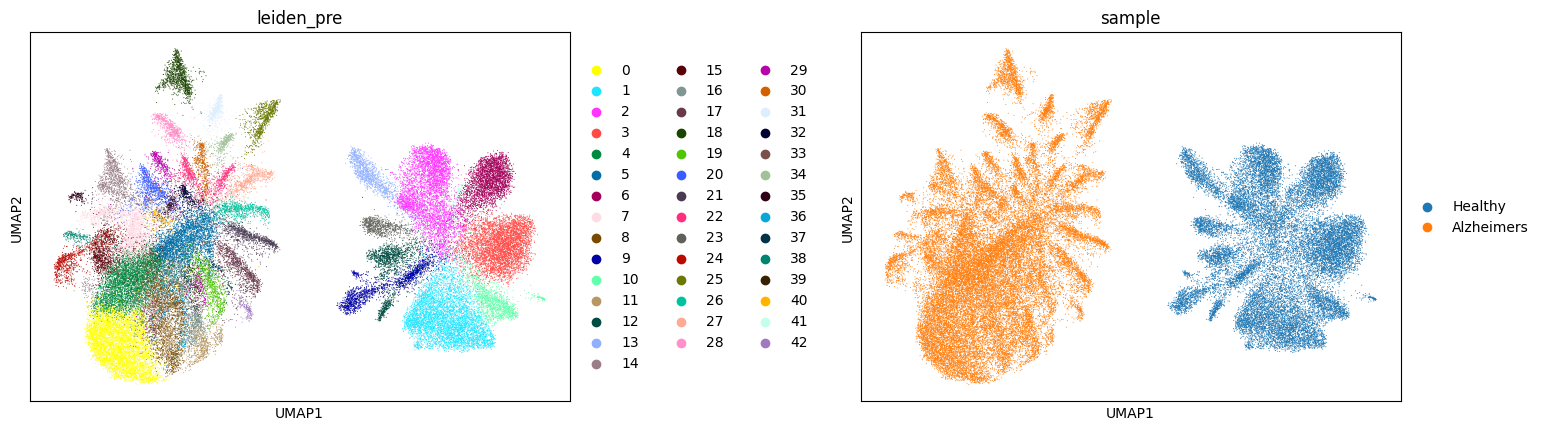

In [71]:
sc.pl.umap(
    adata,
    color=["leiden_pre", "sample"],
    wspace=0.4
)

In [72]:
# harmonization
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=20)

ho = hm.run_harmony(
    adata.obsm["X_pca"],
    adata.obs,
    vars_use=["sample"],
    theta=21, # Increased theta for more aggressive harmonization
    max_iter_harmony=50
)

adata.obsm["X_pca_harmony"] = ho.Z_corr

print("harmonized")

sc.pp.neighbors(
    adata,
    use_rep="X_pca_harmony"
)

2026-01-16 14:27:57,030 - harmonypy - INFO - Running Harmony (PyTorch on cpu)
INFO:harmonypy:Running Harmony (PyTorch on cpu)
2026-01-16 14:27:57,032 - harmonypy - INFO -   Parameters:
INFO:harmonypy:  Parameters:
2026-01-16 14:27:57,038 - harmonypy - INFO -     max_iter_harmony: 50
INFO:harmonypy:    max_iter_harmony: 50
2026-01-16 14:27:57,042 - harmonypy - INFO -     max_iter_kmeans: 20
INFO:harmonypy:    max_iter_kmeans: 20
2026-01-16 14:27:57,047 - harmonypy - INFO -     epsilon_cluster: 1e-05
INFO:harmonypy:    epsilon_cluster: 1e-05
2026-01-16 14:27:57,052 - harmonypy - INFO -     epsilon_harmony: 0.0001
INFO:harmonypy:    epsilon_harmony: 0.0001
2026-01-16 14:27:57,053 - harmonypy - INFO -     nclust: 100
INFO:harmonypy:    nclust: 100
2026-01-16 14:27:57,057 - harmonypy - INFO -     block_size: 0.05
INFO:harmonypy:    block_size: 0.05
2026-01-16 14:27:57,059 - harmonypy - INFO -     lamb: [1. 1.]
INFO:harmonypy:    lamb: [1. 1.]
2026-01-16 14:27:57,064 - harmonypy - INFO -    

harmonized


In [73]:
sc.pp.neighbors(
    adata,
    use_rep="X_pca_harmony"
)
sc.tl.umap(adata)

sc.tl.leiden(adata, key_added="leiden_post")

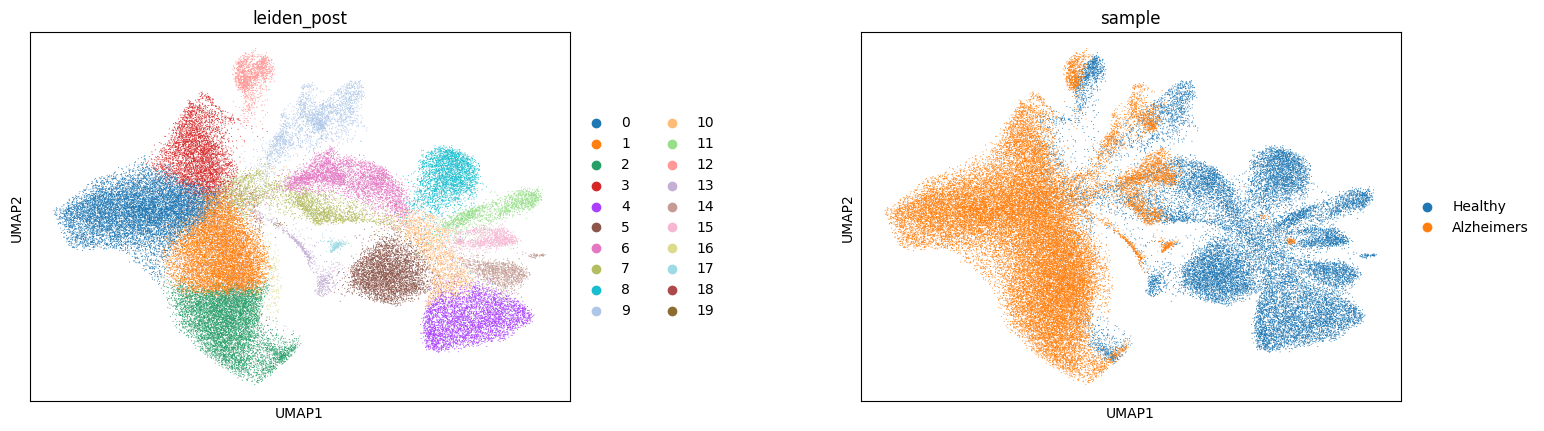

In [74]:
sc.pl.umap(
    adata,
    color=["leiden_post", "sample"],
    wspace=0.4
)

# Analyzing Healthy Cells

Normalization

normalized and log-transform data


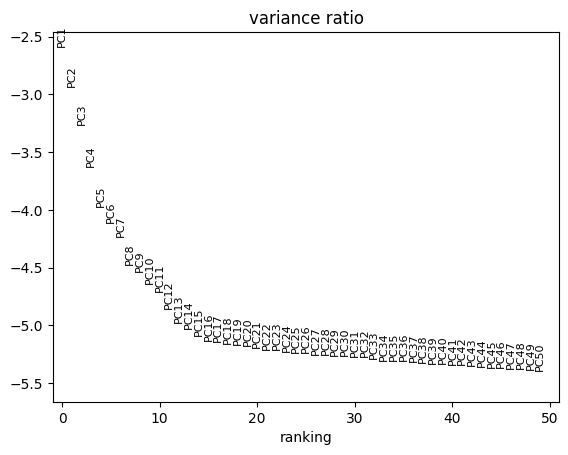

In [75]:
sc.pp.normalize_total(healthy, target_sum=1e4)
sc.pp.log1p(healthy)
sc.tl.pca(healthy)

healthy.raw = healthy

print("normalized and log-transform data")

sc.pl.pca_variance_ratio(healthy, log=True,n_pcs=50)

sc.pp.highly_variable_genes(
    healthy,
    batch_key="condition",
    n_top_genes=3000
)

healthy = healthy[:, healthy.var.highly_variable]

Clustering

In [76]:
sc.pp.scale(healthy, max_value=10)
sc.tl.pca(healthy, n_comps=50)

sc.pp.neighbors(
    healthy,
    use_rep="X_pca"
)
sc.tl.umap(healthy)

sc.tl.leiden(healthy, key_added="leiden", resolution=0.5)

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


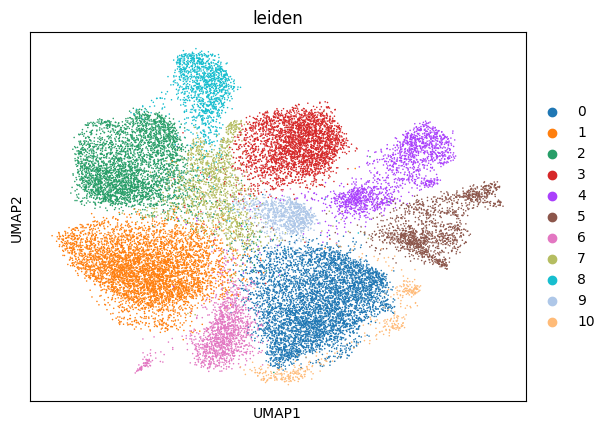

In [77]:
sc.pl.umap(healthy, color = ["leiden"])

Annotation

In [78]:
sc.tl.rank_genes_groups(healthy, 'leiden', method='wilcoxon')
print("Identified marker genes for each 'leiden' cluster within the healthy dataset.")

Identified marker genes for each 'leiden' cluster within the healthy dataset.


In [79]:
sc.tl.rank_genes_groups(healthy, 'leiden', method='wilcoxon')
print("Identified marker genes for each 'leiden' cluster.")

Identified marker genes for each 'leiden' cluster.


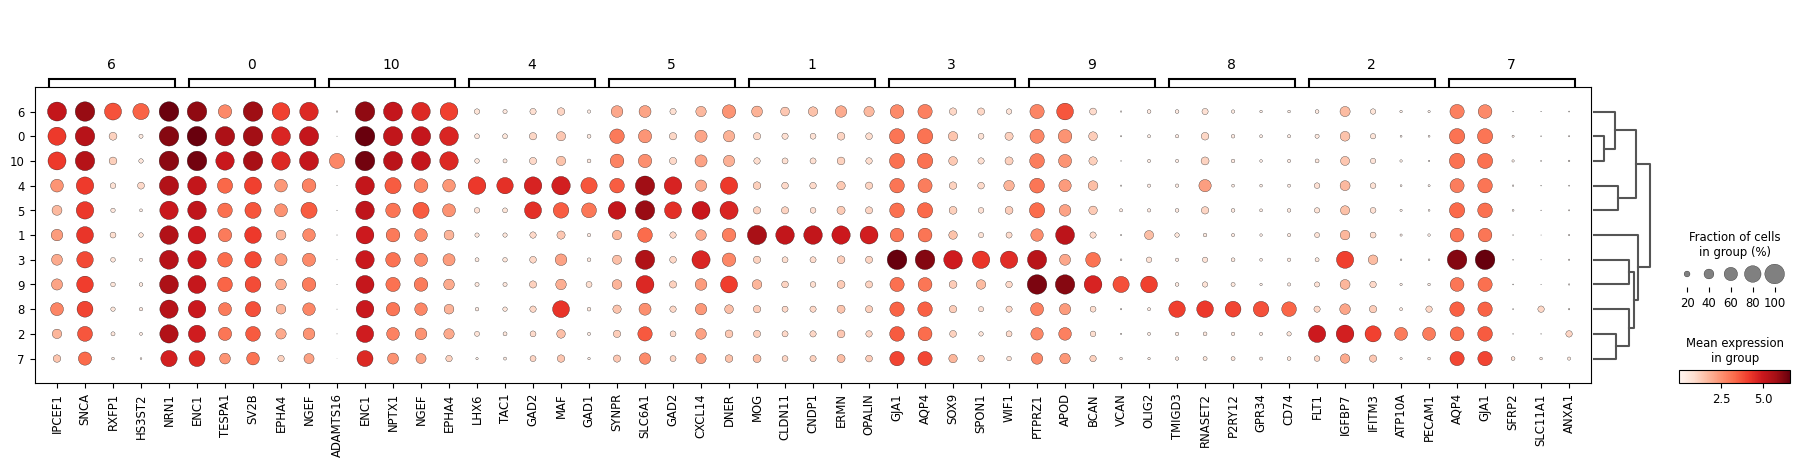

In [80]:
sc.pl.rank_genes_groups_dotplot(healthy, n_genes=5, groupby='leiden', dendrogram=True)

In [81]:
# Define example marker genes for common brain cell types
# You should replace these with specific markers relevant to your dataset and research question.
brain_cell_markers = {
    "Excitatory_Neurons": ["SLC17A7", "GRIN1", "NEUROD2"], # Glutamatergic neurons
    "Inhibitory_Neurons": ["GAD1", "GAD2", "PVALB"], # GABAergic neurons
    "Astrocytes": ["GFAP", "ALDH1L1", "S100B"],
    "Oligodendrocytes": ["MBP", "PLP1", "MOG"],
    "Microglia": ["AIF1", "CD68", "CX3CR1"],
    "Endothelial_Cells": ["CLDN5", "PECAM1", "FLT1"],
    "OPCs": ["PDGFRA", "OLIG2"] # Oligodendrocyte Precursor Cells
}

# Score cells for each marker gene set
for cell_type, markers in brain_cell_markers.items():
    # Filter markers to only include those present in healthy.var_names
    valid_markers = [m for m in markers if m in healthy.var_names]
    if valid_markers:
        sc.tl.score_genes(healthy, valid_markers, score_name=f"score_{cell_type}")
        print(f"Scored cells for {cell_type}")
    else:
        print(f"Warning: No valid markers found for {cell_type} in the dataset. Skipping.")

print("Scoring complete.")

Scored cells for Excitatory_Neurons
Scored cells for Inhibitory_Neurons
Scored cells for Oligodendrocytes
Scored cells for Microglia
Scored cells for Endothelial_Cells
Scored cells for OPCs
Scoring complete.


In [82]:
import pandas as pd

# Get the list of score columns generated previously
score_columns = [col for col in healthy.obs.columns if col.startswith("score_")]

if not score_columns:
    print("No cell type scores found in healthy.obs. Please run the cell type scoring first.")
else:
    # Create a DataFrame with cluster and score information
    cluster_scores = healthy.obs[['leiden'] + score_columns]

    # Calculate the mean score for each cell type within each cluster
    mean_scores_per_cluster = cluster_scores.groupby('leiden')[score_columns].mean()

    # Find the cell type with the highest mean score for each cluster
    # The idxmax() function will return the column label of the first occurrence of the maximum value
    cluster_to_cell_type = mean_scores_per_cluster.idxmax(axis=1)

    # Map the cell type names back to a cleaner format
    cluster_to_cell_type = cluster_to_cell_type.apply(lambda x: x.replace('score_', '').replace('_', ' '))

    # Create a dictionary for mapping leiden_post labels to new cell type annotations
    leiden_annotation_map = cluster_to_cell_type.to_dict()

    # Apply the new annotations to healthy.obs
    healthy.obs['cell_type_annotation'] = healthy.obs['leiden'].map(leiden_annotation_map)

    print("Cell type annotation complete. New annotations stored in 'cell_type_annotation' column.")
    print("Cluster to Cell Type Mapping:")
    print(leiden_annotation_map)


Cell type annotation complete. New annotations stored in 'cell_type_annotation' column.
Cluster to Cell Type Mapping:
{'0': 'Excitatory Neurons', '1': 'Oligodendrocytes', '2': 'Endothelial Cells', '3': 'Microglia', '4': 'Inhibitory Neurons', '5': 'Inhibitory Neurons', '6': 'Excitatory Neurons', '7': 'Excitatory Neurons', '8': 'Microglia', '9': 'OPCs', '10': 'Excitatory Neurons'}


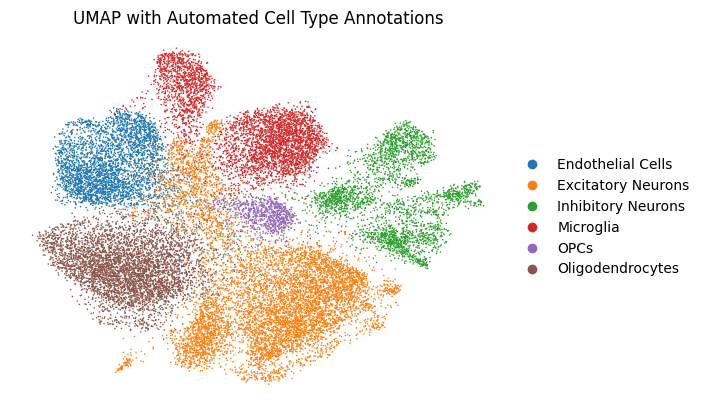

UMAP plot generated with automated cell type annotations.


In [83]:
if 'cell_type_annotation' in healthy.obs.columns:
    sc.pl.umap(
        healthy,
        color='cell_type_annotation',
        frameon=False,
        title='UMAP with Automated Cell Type Annotations'
    )
    print("UMAP plot generated with automated cell type annotations.")
else:
    print("No 'cell_type_annotation' found to plot. Please check previous steps.")

Load Spatial Coordinates for Healthy Data

In [84]:
import pandas as pd

# Define the path to the spatial coordinates file for the healthy sample
# Changed to use cells.csv.gz as per user's instruction
spatial_coords_path = "healthy/cells.csv.gz"

try:
    # Load the spatial coordinates, assuming it has a header and first column is barcode
    spatial_coords = pd.read_csv(
        spatial_coords_path,
        index_col=0, # Assuming the first column is the barcode and should be the index
    )

    print(f"Successfully loaded '{spatial_coords_path}'. First 5 rows:")
    display(spatial_coords.head())
    print(f"Columns in '{spatial_coords_path}':")
    display(spatial_coords.columns)

    # Ensure the order of cells in spatial_coords matches healthy.obs
    spatial_coords = spatial_coords.loc[healthy.obs_names]

    # Manually set the spatial coordinate columns using x_centroid and y_centroid
    coord_cols = ["x_centroid", "y_centroid"]

    if all(col in spatial_coords.columns for col in coord_cols):
        healthy.obsm["spatial"] = spatial_coords[coord_cols].values
        print(f"Spatial coordinates loaded and added to healthy.obsm['spatial'] using columns: {coord_cols[0]}, {coord_cols[1]}.")

        # Add minimal spatial metadata to adata.uns['spatial'] for squidpy compatibility
        # Correcting the nesting: 'generic_spatial_library' should be the key directly under healthy.uns['spatial']
        healthy.uns["spatial"] = {}
        healthy.uns["spatial"]["generic_spatial_library"] = {
            "images": {"hires": None}, # Placeholder for image, as we don't have one
            "scalefactors": {"tissue_hires_scalef": 1.0, "spot_diameter_fullres": 1.0}, # Dummy scale factors
        }
        print("Minimal spatial metadata added to healthy.uns['spatial'] for squidpy.")

    else:
        print("Error: Expected spatial coordinate columns 'x_centroid' and 'y_centroid' not found in 'cells.csv.gz'.")

except FileNotFoundError:
    print(f"Error: Spatial coordinates file not found at {spatial_coords_path}.")
    print("Please ensure the path is correct and the file exists.")
except KeyError as e:
    print(f"Error processing spatial coordinates or matching barcodes: {e}")
    print("Ensure 'barcode' column matches healthy.obs_names and other expected columns are present.")

Successfully loaded 'healthy/cells.csv.gz'. First 5 rows:


,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,total_counts,cell_area,nucleus_area
cell_id,,,,,,,,,
aaaaieod-1,839.081360,4619.424609,271,0,0,0,271,942.140000,33.686563
aaadabdh-1,1658.357056,4684.061548,263,0,0,0,263,889.126563,32.693125
aaaepfof-1,1672.080115,4731.621289,314,0,0,0,314,1028.072344,29.893438
aaanldfc-1,850.676617,4744.803345,209,0,0,0,209,332.711250,30.841719
aaaonnnp-1,831.098343,4746.391284,249,0,0,0,249,587.618281,36.847500


Columns in 'healthy/cells.csv.gz':


Index(['x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts',
       'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts',
       'cell_area', 'nucleus_area'],
      dtype='object')

Spatial coordinates loaded and added to healthy.obsm['spatial'] using columns: x_centroid, y_centroid.
Minimal spatial metadata added to healthy.uns['spatial'] for squidpy.


In [85]:
custom_colors = {
    'Endothelial Cells': 'blue',
    'Excitatory Neurons': 'orange',
    'Inhibitory Neurons': 'green',
    'OPCs': 'purple',
    'Astrocytes': 'brown',
    'Microglia': 'red',  # Added color for Microglia
    'Oligodendrocytes': 'pink' # Added color for Oligodendrocytes
}

### Visualize Cell Types on Spatial Plot

Now that spatial coordinates are loaded, we can use `squidpy.pl.spatial_scatter` to visualize the cell type annotations directly on the tissue. This will help us understand the spatial distribution of different cell types in the healthy sample.

# Analyzing Alzheimers Cells

Normalization

normalized and log-transform data


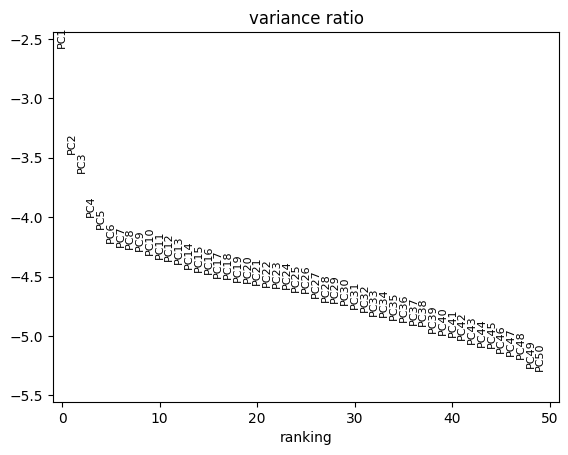

In [87]:
sc.pp.normalize_total(alz, target_sum=1e4)
sc.pp.log1p(alz)
sc.tl.pca(alz)

alz.raw = alz

print("normalized and log-transform data")

sc.pl.pca_variance_ratio(alz, log=True,n_pcs=50)

sc.pp.highly_variable_genes(
    alz,
    batch_key="condition",
    n_top_genes=3000
)

alz = alz[:, alz.var.highly_variable]

Clustering

In [88]:
sc.pp.scale(alz, max_value=10)
sc.tl.pca(alz, n_comps=50)

sc.pp.neighbors(
    alz,
    use_rep="X_pca"
)
sc.tl.umap(alz)

sc.tl.leiden(alz, key_added="leiden", resolution=0.5)

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


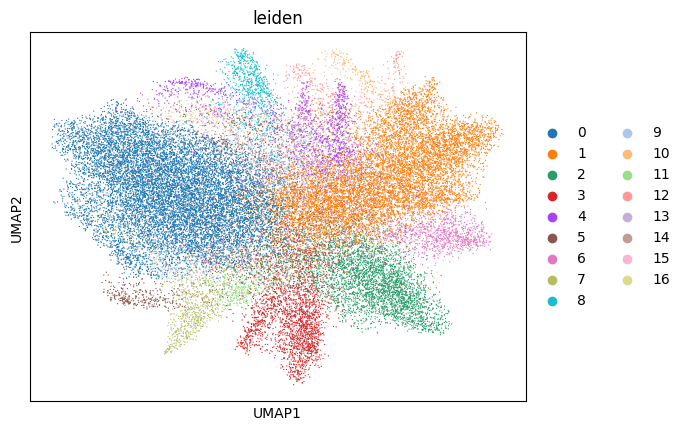

In [89]:
sc.pl.umap(alz, color = ["leiden"])

Annotation

In [90]:
sc.tl.rank_genes_groups(alz, 'leiden', method='wilcoxon')
print("Identified marker genes for each 'leiden' cluster within the alz dataset.")

Identified marker genes for each 'leiden' cluster within the alz dataset.


In [91]:
sc.tl.rank_genes_groups(alz, 'leiden', method='wilcoxon')
print("Identified marker genes for each 'leiden_post' cluster.")

Identified marker genes for each 'leiden_post' cluster.


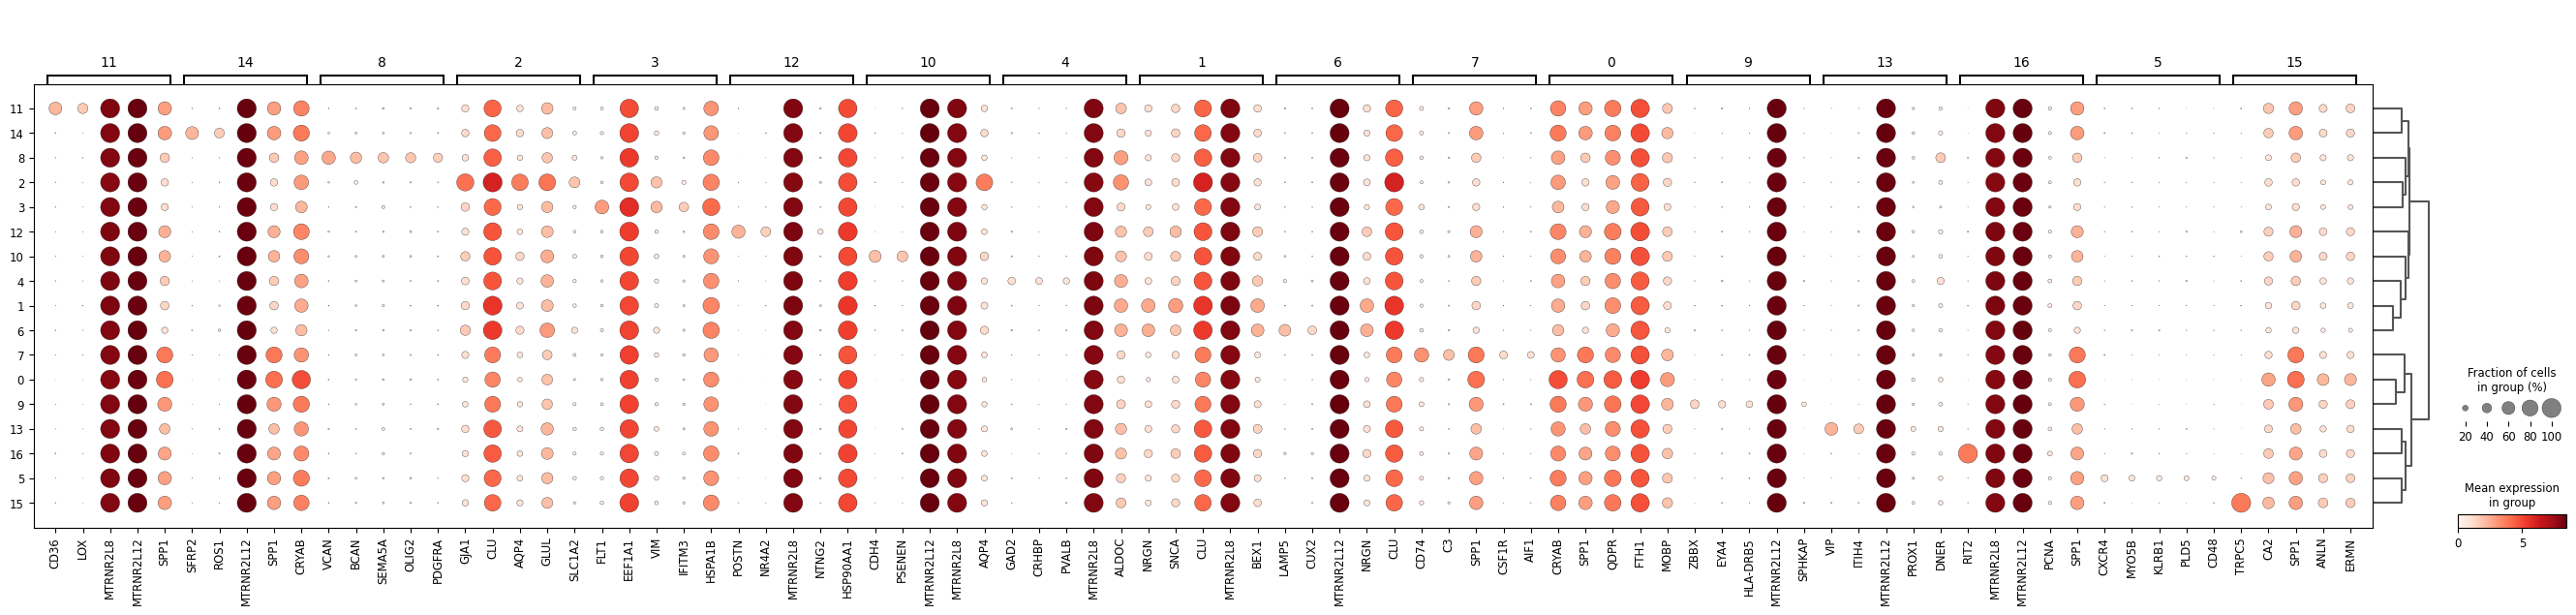

In [92]:
sc.pl.rank_genes_groups_dotplot(alz, n_genes=5, groupby='leiden', dendrogram=True)

In [93]:
# Define example marker genes for common brain cell types
# You should replace these with specific markers relevant to your dataset and research question.
brain_cell_markers = {
    "Excitatory_Neurons": ["SLC17A7", "GRIN1", "NEUROD2"], # Glutamatergic neurons
    "Inhibitory_Neurons": ["GAD1", "GAD2", "PVALB"], # GABAergic neurons
    "Astrocytes": ["GFAP", "ALDH1L1", "S100B"],
    "Oligodendrocytes": ["MBP", "PLP1", "MOG"],
    "Microglia": ["AIF1", "CD68", "CX3CR1"],
    "Endothelial_Cells": ["CLDN5", "PECAM1", "FLT1"],
    "OPCs": ["PDGFRA", "OLIG2"] # Oligodendrocyte Precursor Cells
}

total=0
brain_cell_amt = {
    "Excitatory_Neurons": 0, # Glutamatergic neurons
    "Inhibitory_Neurons": 0, # GABAergic neurons
    "Astrocytes": 0,
    "Oligodendrocytes": 0,
    "Microglia": 0,
    "Endothelial_Cells": 0,
    "OPCs": 0 # Oligodendrocyte Precursor Cells
}

# Score cells for each marker gene set
for cell_type, markers in brain_cell_markers.items():
    # Filter markers to only include those present in alz.var_names
    valid_markers = [m for m in markers if m in alz.var_names]
    if valid_markers:
        sc.tl.score_genes(alz, valid_markers, score_name=f"score_{cell_type}")
        print(f"Scored cells for {cell_type}")
    else:
        print(f"Warning: No valid markers found for {cell_type} in the dataset. Skipping.")

print("Scoring complete.")

Scored cells for Excitatory_Neurons
Scored cells for Inhibitory_Neurons
Scored cells for Astrocytes
Scored cells for Microglia
Scored cells for Endothelial_Cells
Scored cells for OPCs
Scoring complete.


### Percentage of Cells Per Type

Let's calculate the percentage of cells belonging to each identified cell type for both the healthy and Alzheimer's datasets to understand their cellular composition.

In [94]:
import pandas as pd

print("### Cell Type Proportions in Healthy Dataset ###")
if 'cell_type_annotation' in healthy.obs.columns:
    healthy_cell_type_counts = healthy.obs['cell_type_annotation'].value_counts()
    healthy_cell_type_percentages = (healthy_cell_type_counts / healthy_cell_type_counts.sum()) * 100
    display(pd.DataFrame({'Count': healthy_cell_type_counts, 'Percentage': healthy_cell_type_percentages.round(2)}))
else:
    print("Cell type annotations not found for healthy data.")

print("\n### Cell Type Proportions in Alzheimer's Dataset ###")
if 'cell_type_annotation' in alz.obs.columns:
    alz_cell_type_counts = alz.obs['cell_type_annotation'].value_counts()
    alz_cell_type_percentages = (alz_cell_type_counts / alz_cell_type_counts.sum()) * 100
    display(pd.DataFrame({'Count': alz_cell_type_counts, 'Percentage': alz_cell_type_percentages.round(2)}))
else:
    print("Cell type annotations not found for Alzheimer's data.")

### Cell Type Proportions in Healthy Dataset ###


,Count,Percentage
cell_type_annotation,,
Excitatory Neurons,7937,33.01
Oligodendrocytes,4649,19.34
Microglia,4119,17.13
Endothelial Cells,3456,14.37
Inhibitory Neurons,3049,12.68
OPCs,833,3.46



### Cell Type Proportions in Alzheimer's Dataset ###
Cell type annotations not found for Alzheimer's data.


In [95]:
import pandas as pd

# Get the list of score columns generated previously
score_columns = [col for col in alz.obs.columns if col.startswith("score_")]

if not score_columns:
    print("No cell type scores found in alz.obs. Please run the cell type scoring first.")
else:
    # Create a DataFrame with cluster and score information
    cluster_scores = alz.obs[['leiden'] + score_columns]

    # Calculate the mean score for each cell type within each cluster
    mean_scores_per_cluster = cluster_scores.groupby('leiden')[score_columns].mean()

    # Find the cell type with the highest mean score for each cluster
    # The idxmax() function will return the column label of the first occurrence of the maximum value
    cluster_to_cell_type = mean_scores_per_cluster.idxmax(axis=1)

    # Map the cell type names back to a cleaner format
    cluster_to_cell_type = cluster_to_cell_type.apply(lambda x: x.replace('score_', '').replace('_', ' '))

    # Create a dictionary for mapping leiden_post labels to new cell type annotations
    leiden_annotation_map = cluster_to_cell_type.to_dict()

    # Apply the new annotations to alz.obs
    alz.obs['cell_type_annotation'] = alz.obs['leiden'].map(leiden_annotation_map)

    print("Cell type annotation complete. New annotations stored in 'cell_type_annotation' column.")
    print("Cluster to Cell Type Mapping:")
    print(leiden_annotation_map)


Cell type annotation complete. New annotations stored in 'cell_type_annotation' column.
Cluster to Cell Type Mapping:
{'0': 'Astrocytes', '1': 'Excitatory Neurons', '2': 'Astrocytes', '3': 'Endothelial Cells', '4': 'Inhibitory Neurons', '5': 'Astrocytes', '6': 'Astrocytes', '7': 'Astrocytes', '8': 'OPCs', '9': 'Astrocytes', '10': 'Astrocytes', '11': 'Astrocytes', '12': 'Astrocytes', '13': 'Astrocytes', '14': 'Astrocytes', '15': 'Astrocytes', '16': 'Astrocytes'}


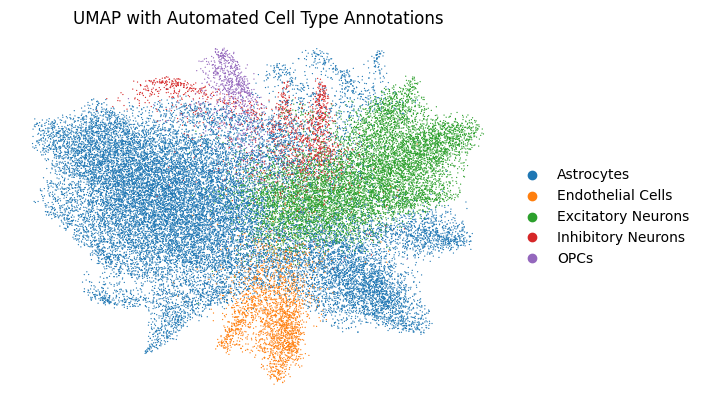

UMAP plot generated with automated cell type annotations.


In [96]:
if 'cell_type_annotation' in alz.obs.columns:
    sc.pl.umap(
        alz,
        color='cell_type_annotation',
        frameon=False,
        title='UMAP with Automated Cell Type Annotations'
    )
    print("UMAP plot generated with automated cell type annotations.")
else:
    print("No 'cell_type_annotation' found to plot. Please check previous steps.")

Load Spatial Coordinates for Alz Data

In [97]:
import pandas as pd

# Define the path to the spatial coordinates file for the alz sample
# Changed to use cells.csv.gz as per user's instruction
spatial_coords_path = "alzheimers/cells.csv.gz"

try:
    # Load the spatial coordinates, assuming it has a header and first column is barcode
    spatial_coords = pd.read_csv(
        spatial_coords_path,
        index_col=0, # Assuming the first column is the barcode and should be the index
    )

    print(f"Successfully loaded '{spatial_coords_path}'. First 5 rows:")
    display(spatial_coords.head())
    print(f"Columns in '{spatial_coords_path}':")
    display(spatial_coords.columns)

    # Ensure the order of cells in spatial_coords matches alz.obs
    spatial_coords = spatial_coords.loc[alz.obs_names]

    # Manually set the spatial coordinate columns using x_centroid and y_centroid
    coord_cols = ["x_centroid", "y_centroid"]

    if all(col in spatial_coords.columns for col in coord_cols):
        alz.obsm["spatial"] = spatial_coords[coord_cols].values
        print(f"Spatial coordinates loaded and added to alz.obsm['spatial'] using columns: {coord_cols[0]}, {coord_cols[1]}.")

        # Add minimal spatial metadata to adata.uns['spatial'] for squidpy compatibility
        # Correcting the nesting: 'generic_spatial_library' should be the key directly under alz.uns['spatial']
        alz.uns["spatial"] = {}
        alz.uns["spatial"]["generic_spatial_library"] = {
            "images": {"hires": None}, # Placeholder for image, as we don't have one
            "scalefactors": {"tissue_hires_scalef": 1.0, "spot_diameter_fullres": 1.0}, # Dummy scale factors
        }
        print("Minimal spatial metadata added to alz.uns['spatial'] for squidpy.")

    else:
        print("Error: Expected spatial coordinate columns 'x_centroid' and 'y_centroid' not found in 'cells.csv.gz'.")

except FileNotFoundError:
    print(f"Error: Spatial coordinates file not found at {spatial_coords_path}.")
    print("Please ensure the path is correct and the file exists.")
except KeyError as e:
    print(f"Error processing spatial coordinates or matching barcodes: {e}")
    print("Ensure 'barcode' column matches alz.obs_names and other expected columns are present.")

Successfully loaded 'alzheimers/cells.csv.gz'. First 5 rows:


,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,total_counts,cell_area,nucleus_area
cell_id,,,,,,,,,
aaabkbfm-1,2252.807544,2549.970117,201,0,1,0,202,588.566563,17.610938
aaabpecp-1,2288.217847,2543.900378,272,0,0,0,272,793.169531,32.331875
aaacpeaj-1,2367.438220,1693.450165,232,0,0,0,232,942.862500,27.229219
aaaejeni-1,2483.150281,1705.950104,103,0,0,0,103,209.705625,18.333437
aaaejnkk-1,2342.141589,2532.635596,240,0,0,0,240,631.600469,34.092969


Columns in 'alzheimers/cells.csv.gz':


Index(['x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts',
       'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts',
       'cell_area', 'nucleus_area'],
      dtype='object')

Spatial coordinates loaded and added to alz.obsm['spatial'] using columns: x_centroid, y_centroid.
Minimal spatial metadata added to alz.uns['spatial'] for squidpy.


### Visualize Cell Types on Spatial Plot

Now that spatial coordinates are loaded, we can use `squidpy.pl.spatial_scatter` to visualize the cell type annotations directly on the tissue. This will help us understand the spatial distribution of different cell types in the healthy sample.

In [98]:
custom_colors = {
    'Endothelial Cells': 'blue',
    'Excitatory Neurons': 'orange',
    'Inhibitory Neurons': 'green',
    'OPCs': 'purple',
    'Astrocytes': 'brown',
    'Microglia': 'red',
    'Oligodendrocytes': 'pink'
}

Spatial visualization of alz cell types generated.


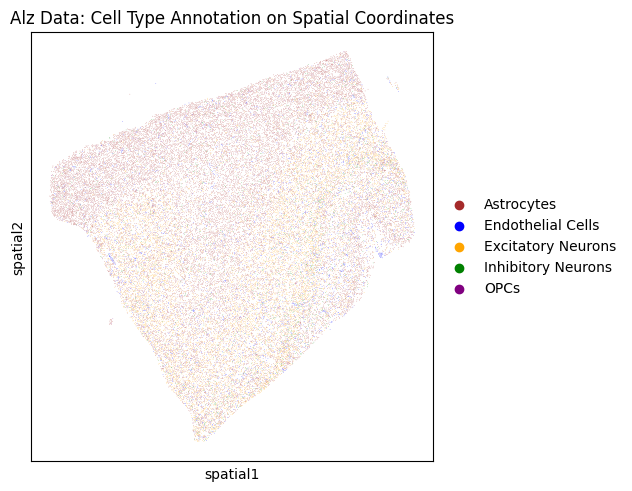

In [99]:
import squidpy as sq
import matplotlib.colors as mcolors

# Ensure minimal spatial metadata is present for squidpy compatibility
# This is added here to ensure it's always present on the 'alz' object being plotted,
# in case previous subsetting operations caused it to be lost from .uns
if "spatial" not in alz.uns:
    alz.uns["spatial"] = {}
if "generic_spatial_library" not in alz.uns["spatial"]:
    # Using a generic library_id, you can change this if you have a specific one
    alz.uns["spatial"]["generic_spatial_library"] = {
        "images": {"hires": None}, # Placeholder for image, as we don't have one
        "scalefactors": {"tissue_hires_scalef": 1.0, "spot_diameter_fullres": 1.0}, # Dummy scale factors
    }
    print("Minimal spatial metadata added to alz.uns['spatial'] for squidpy within the plotting cell.")

# Convert the custom_colors dictionary to a ListedColormap
# This is necessary because squidpy.pl.spatial_scatter expects a colormap object or string, not a dict.
if 'cell_type_annotation' in alz.obs.columns:
    # Get all unique cell types from the data
    unique_cell_types = alz.obs['cell_type_annotation'].cat.categories.tolist()

    # Create a list of colors in the same order as unique_cell_types, using custom_colors if available
    # Fallback to a default color (e.g., 'gray') or use a different colormap for types not in custom_colors
    colors_for_colormap = [custom_colors.get(ct, 'gray') for ct in unique_cell_types]
    custom_listed_colormap = mcolors.ListedColormap(colors_for_colormap)

    # Now, proceed with the spatial scatter plot
    sq.pl.spatial_scatter(
        alz,
        color="cell_type_annotation",
        size=10, # Adjust spot size as needed
        legend_loc='right margin',
        title="Alz Data: Cell Type Annotation on Spatial Coordinates",
        library_id="generic_spatial_library", # Explicitly specify the library_id we just created
        img=False, # Explicitly tell squidpy not to load an image
        palette=custom_listed_colormap
    )
    print("Spatial visualization of alz cell types generated.")
elif "spatial" not in alz.obsm:
    print("Spatial coordinates not found in alz.obsm. Cannot generate spatial scatter plot.")
else:
    print("Cell type annotations not found in alz.obs. Please run cell type annotation first.")

In [100]:
import pandas as pd

# Define the path to the cell boundaries file for the healthy sample
boundaries_path = "healthy/cell_boundaries.csv.gz"

try:
    # Load the cell boundaries file, assuming it has a header
    # and the first column is the cell barcode (cell_id), which should be the index
    cell_boundaries = pd.read_csv(
        boundaries_path,
        index_col=0, # Assuming the first column is the cell_id and should be the index
        # Let header=0 (default) and infer column names from the first row
    )

    print(f"Successfully loaded '{boundaries_path}'. First 5 rows:")
    display(cell_boundaries.head())
    print(f"Columns in '{boundaries_path}':")
    display(cell_boundaries.columns)
    print(f"Data types in '{boundaries_path}':")
    display(cell_boundaries.dtypes)

except FileNotFoundError:
    print(f"Error: Cell boundaries file not found at {boundaries_path}.")
    print("Please ensure the path is correct and the file exists.")
except Exception as e:
    print(f"An error occurred while loading cell boundaries: {e}")

Successfully loaded 'healthy/cell_boundaries.csv.gz'. First 5 rows:


,vertex_x,vertex_y
cell_id,,
aaaaieod-1,835.5500,4602.1123
aaaaieod-1,822.3750,4613.5874
aaaaieod-1,820.0375,4621.2373
aaaaieod-1,825.5625,4631.6500
aaaaieod-1,837.6750,4636.1123


Columns in 'healthy/cell_boundaries.csv.gz':


Index(['vertex_x', 'vertex_y'], dtype='object')

Data types in 'healthy/cell_boundaries.csv.gz':


,0
vertex_x,float64
vertex_y,float64


# Differential Gene Expression Analysis

In [102]:
!pip install pydeseq2

In [103]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [104]:
import scanpy as sc
import pandas as pd
import numpy as np

# Define the cell type of interest
cell_type_of_interest = "Excitatory Neurons"

# --- Process Healthy Data ---
healthy_excitatory = None
if 'cell_type_annotation' in healthy.obs.columns:
    healthy_excitatory = healthy[healthy.obs['cell_type_annotation'] == cell_type_of_interest].copy()
    if healthy_excitatory.n_obs == 0:
        print(f"No {cell_type_of_interest} found in healthy dataset.")
    else:
        print(f"Found {healthy_excitatory.n_obs} {cell_type_of_interest} in healthy dataset.")
else:
    print("Error: 'cell_type_annotation' not found in healthy.obs. Please run cell type annotation for healthy data first.")

# --- Process Alzheimer's Data ---
alz_excitatory = None
if 'cell_type_annotation' in alz.obs.columns:
    alz_excitatory = alz[alz.obs['cell_type_annotation'] == cell_type_of_interest].copy()
    if alz_excitatory.n_obs == 0:
        print(f"No {cell_type_of_interest} found in Alzheimer's dataset.")
    else:
        print(f"Found {alz_excitatory.n_obs} {cell_type_of_interest} in Alzheimer's dataset.")
else:
    print("Error: 'cell_type_annotation' not found in alz.obs. Please run cell type annotation for Alzheimer's data first.")

# --- Pseudobulk Aggregation and DataFrame Creation ---
if healthy_excitatory is not None and healthy_excitatory.n_obs > 0 and \
   alz_excitatory is not None and alz_excitatory.n_obs > 0:

    # Get genes from raw data, which contains all genes before HVG selection
    # Use .raw.var_names if raw exists, otherwise fall back to .var_names after filtering
    healthy_genes_in_raw = healthy_excitatory.raw.var_names if healthy_excitatory.raw else healthy_excitatory.var_names
    alz_genes_in_raw = alz_excitatory.raw.var_names if alz_excitatory.raw else alz_excitatory.var_names

    # Find common genes for comparison
    common_genes = list(set(healthy_genes_in_raw) & set(alz_genes_in_raw))
    if not common_genes:
        print("No common genes found between healthy and Alzheimer's excitatory neurons for DGE.")
    else:
        print(f"Found {len(common_genes)} common genes for DGE.")

        # Extract and sum raw counts for common genes
        if healthy_excitatory.raw:
            healthy_pseudobulk_counts = healthy_excitatory.raw[:, common_genes].X.sum(axis=0)
        else:
            # Fallback if .raw is not available, but user specified to use raw counts
            # This case should ideally not be reached if .raw was set correctly upstream
            print("Warning: healthy.raw not found. Using processed X for healthy pseudobulk.")
            healthy_pseudobulk_counts = healthy_excitatory[:, common_genes].X.sum(axis=0)

        if alz_excitatory.raw:
            alz_pseudobulk_counts = alz_excitatory.raw[:, common_genes].X.sum(axis=0)
        else:
            print("Warning: alz.raw not found. Using processed X for Alzheimer's pseudobulk.")
            alz_pseudobulk_counts = alz_excitatory[:, common_genes].X.sum(axis=0)

        # Ensure counts are in a 2D array for DataFrame creation
        healthy_pseudobulk_counts = np.asarray(healthy_pseudobulk_counts).flatten()
        alz_pseudobulk_counts = np.asarray(alz_pseudobulk_counts).flatten()

        # Create counts_df
        counts_df = pd.DataFrame(
            [healthy_pseudobulk_counts, alz_pseudobulk_counts],
            index=["Healthy", "Alzheimers"],
            columns=common_genes
        ).astype(int)

        # Create metadata_df
        metadata_df = pd.DataFrame(
            {
                'condition': ["Healthy", "Alzheimers"]
            },
            index=["Healthy", "Alzheimers"]
        )

        print(f"\nPseudobulk data for differential gene expression analysis of {cell_type_of_interest} prepared.")
        print("Counts DataFrame (first 5 genes):")
        display(counts_df.iloc[:, :5])
        print("Metadata DataFrame:")
        display(metadata_df)

else:
    print(f"Cannot prepare DGE data: Insufficient {cell_type_of_interest} cells in one or both datasets.")

Found 3049 Inhibitory Neurons in healthy dataset.
Found 1620 Inhibitory Neurons in Alzheimer's dataset.
Found 264 common genes for DGE.

Pseudobulk data for differential gene expression analysis of Inhibitory Neurons prepared.
Counts DataFrame (first 5 genes):


,PVALB,CD48,PDGFD,CDH12,CD14
Healthy,6164,16,1189,3648,257
Alzheimers,1459,34,107,169,37


Metadata DataFrame:


,condition
Healthy,Healthy
Alzheimers,Alzheimers


**Reasoning**:
The previous `pydeseq2` code failed with a `ValueError` because DESeq2 requires biological replicates (multiple samples per condition) to estimate dispersion, and the current pseudobulk data only contains one 'Healthy' and one 'Alzheimers' sample. To perform differential gene expression analysis with the available pseudobulk data, I will switch to `scanpy.tl.rank_genes_groups` using the 'wilcoxon' method, which can compare two groups without requiring replicates. This involves converting the pseudobulk `counts_df` and `metadata_df` into a `scanpy.AnnData` object.



In [105]:
import scanpy as sc
import pandas as pd
import numpy as np

# Define the cell type of interest (already defined in previous cell output)
cell_type_of_interest = "Excitatory Neurons"

# Ensure healthy_excitatory and alz_excitatory exist from the previous step
if 'healthy_excitatory' not in locals() or healthy_excitatory is None or healthy_excitatory.n_obs == 0:
    print(f"Error: No {cell_type_of_interest} data available for healthy condition. Please check previous steps.")
elif 'alz_excitatory' not in locals() or alz_excitatory is None or alz_excitatory.n_obs == 0:
    print(f"Error: No {cell_type_of_interest} data available for Alzheimer's condition. Please check previous steps.")
else:
    # Concatenate the individual endothelial cell AnnData objects
    # It's crucial to use the raw counts for DGE if available
    # Ensure .raw is set before concatenation if you intend to use it
    # Re-setting .raw explicitly if it might have been lost or not correctly propagated
    if not hasattr(healthy_excitatory, 'raw') or healthy_excitatory.raw is None:
        healthy_excitatory.raw = healthy_excitatory # Use itself as raw if not explicitly set
    if not hasattr(alz_excitatory, 'raw') or alz_excitatory.raw is None:
        alz_excitatory.raw = alz_excitatory # Use itself as raw if not explicitly set

    # Make sure 'condition' is present in obs for concatenation
    healthy_excitatory.obs['condition'] = 'Healthy'
    alz_excitatory.obs['condition'] = 'Alzheimers'

    # Ensure unique var_names before concatenation for robust merging
    healthy_excitatory.var_names_make_unique()
    alz_excitatory.var_names_make_unique()

    combined_endothelial_adata = sc.AnnData.concatenate(
        healthy_excitatory,
        alz_excitatory,
        batch_key='condition',
        batch_categories=['Healthy', 'Alzheimers'],
        join='outer',
        fill_value=0 # Fill missing genes with 0 counts
    )

    # Ensure the 'condition' column is categorical
    combined_endothelial_adata.obs['condition'] = combined_endothelial_adata.obs['condition'].astype('category')

    # Set raw attribute for the combined adata if it's not already there
    # This ensures rank_genes_groups uses the unnormalized counts
    if combined_endothelial_adata.raw is None:
        combined_endothelial_adata.raw = combined_endothelial_adata

    print(f"Performing differential gene expression analysis for {cell_type_of_interest} using scanpy.tl.rank_genes_groups (Wilcoxon test).")

    # Perform differential gene expression analysis using Wilcoxon rank-sum test
    sc.tl.rank_genes_groups(
        combined_endothelial_adata,
        groupby='condition',
        method='wilcoxon',
        key_added='wilcoxon_de',
        reference='Healthy' # Compare Alzheimers against Healthy
    )

    # Extract and print the top differentially expressed genes
    result = combined_endothelial_adata.uns['wilcoxon_de']
    groups = result['names'].dtype.names

    print(f"\nTop 10 differentially expressed genes (Alzheimers vs Healthy for {cell_type_of_interest}):\n")
    for group in groups:
        if group != 'Healthy': # Only interested in Alzheimers vs Healthy reference
            print(f"--- Group: {group} ---")
            # Create a DataFrame for better readability
            de_genes_df = pd.DataFrame({
                'names': result['names'][group],
                'logfoldchanges': result['logfoldchanges'][group],
                'pvals_adj': result['pvals_adj'][group]
            })
            # Filter out NaNs if any (can happen for pvals_adj)
            de_genes_df = de_genes_df.dropna()
            # Sort by logfoldchanges to see up/down-regulated genes
            # Top 10 up-regulated
            print("Top 10 up-regulated genes:")
            print(de_genes_df.sort_values(by='logfoldchanges', ascending=False).head(10).to_string(index=False))
            print("\nTop 10 down-regulated genes:")
            print(de_genes_df.sort_values(by='logfoldchanges', ascending=True).head(10).to_string(index=False))

    print(f"\nDifferential gene expression analysis for {cell_type_of_interest} complete.")

Performing differential gene expression analysis for Inhibitory Neurons using scanpy.tl.rank_genes_groups (Wilcoxon test).

Top 10 differentially expressed genes (Alzheimers vs Healthy for Inhibitory Neurons):

--- Group: Alzheimers ---
Top 10 up-regulated genes:
    names  logfoldchanges  pvals_adj
MTRNR2L12       42.039661        0.0
 MTRNR2L8       41.517872        0.0
 HSP90AA1       37.493111        0.0
   EEF1A1       37.139893        0.0
      CLU       36.701988        0.0
     FTH1       36.446121        0.0
      FTL       34.864937        0.0
     QDPR       34.616322        0.0
   HSPA1B       34.559383        0.0
     GFAP       33.944374        0.0

Top 10 down-regulated genes:
 names  logfoldchanges  pvals_adj
SLC6A1      -38.324497        0.0
  PRNP      -37.477810        0.0
  NRN1      -37.445194        0.0
  ENC1      -37.308266        0.0
 PARK7      -37.291416        0.0
  RGS4      -36.986675        0.0
SPOCK3      -36.819878        0.0
   CCK      -36.650642     